# Transaction Data Collection from the Ethereum Blockchain

## EIP-1559
- Date: August 5, 2021
- Block number: 12,965,000
- [Ethereum JSON-RPC Specification](https://ethereum.github.io/execution-apis/api-documentation/)
- [JSON RPC API](https://ethereum.org/en/developers/docs/apis/json-rpc/)
- [EIP-1559 Analysis Arxiv](https://github.com/SciEcon/EIP1559)

## Layer 2 Solutions Launch Dates
Source: [L2BEAT](https://l2beat.com/scaling/tvl)
1. Optimism is live on: January 16, 2021
2. Arbitrum is live on: August 31, 2021

In [27]:
# !pip install dask
# !pip install pyspark
# !pip install matplotlib
# !pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [49]:
import datetime
import csv
import os
import re
import glob
from datetime import datetime
import time

import numpy as np
import pandas as pd
import dask.dataframe as dd
from collections import defaultdict

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, unix_timestamp, round, to_timestamp, lit, when, sum, row_number, date_format, to_date, from_unixtime
from pyspark.sql.types import TimestampType
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns
# Set the style of seaborn
sns.set(style="whitegrid")

In [2]:
def timestamp(date_string):
    """
    Convert a date string to a Unix timestamp.
    
    Args:
        date_string (str): The date string in 'YYYY-MM-DD' format.
    
    Returns:
        int: The Unix timestamp corresponding to the date string.
    """
    dt = datetime.strptime(date_string, "%Y-%m-%d")
    return int(dt.timestamp())


### Merge transaction data
Here, I merge transaction data for just three days for checking code implementation since I do not have the complete dataset yet.

In [3]:
# Directory where your files are stored
data_dir = "../data/"

# Filename pattern
filename_pattern = "eth_transaction_data_{}.csv"

# Find all filenames in the directory
all_files = os.listdir(data_dir)

# Extract dates from filenames and convert to datetime
dates = [datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', file).group(), "%Y-%m-%d") for file in all_files if re.search(r'\d{4}-\d{2}-\d{2}', file)]

# Find start and end dates
start_date = min(dates)
end_date = max(dates)

# Flag to indicate whether it's the first file
first_file = True

# Create or open the final CSV file in append mode
with open(f"{data_dir}merged_eth_transaction_data.csv", 'a') as singleFile:
    for single_date in pd.date_range(start_date, end_date):
        filename = os.path.join(data_dir, filename_pattern.format(single_date.strftime("%Y-%m-%d")))
        
        if os.path.isfile(filename):  # if the file exists
            df = pd.read_csv(filename, dtype={5: float})
            # Write data to file
            if first_file:  # If it's the first file
                df.to_csv(singleFile, header=True)  # Write with header
                first_file = False  # After the first file, set this flag to False
            else:
                df.to_csv(singleFile, header=False, mode='a')  # If not the first file, write without header

### Data preprocessing
Given the large size of your data, traditional Python tools like Pandas might not be able to handle it efficiently due to memory constraints. Fortunately, there are tools and libraries built specifically for handling larger-than-memory datasets, such as Dask and Vaex.

1. **Dask**: Dask is a flexible library for parallel computing in Python that's built on top of existing Python APIs and data structures, like NumPy arrays and Pandas DataFrames. It can handle larger-than-memory computations by breaking them down into smaller tasks, executing these tasks in parallel and combining the results.


2. **Vaex**: Vaex is another library for handling large datasets. Like Dask, it performs lazy evaluations and only reads in data when necessary. Its API is also similar to Pandas, which makes it easy to use if you're familiar with Pandas:

In either case, you should ensure that your machine has enough storage to hold the intermediate results of the computations. Also, both Dask and Vaex make use of multiple cores, so having a multi-core machine can speed up the computations.

In Dask, the way to read and modify columns is similar to pandas. You can use Dask's `read_csv` function to read the CSV file and then apply the string operations to the column names using the `rename` method. Here's how you can adapt your code to use Dask:

In [4]:
# Specify the data types
dtypes = {
    'Transaction Identifier': str,
    'Transaction Status': str,
    'Transaction Fee': float,
    'Sender\'s Address': str,
    'Transaction Type': str,
    'Transaction EIP-1559 Type': str
}

# Read the CSV file into a DataFrame
df = dd.read_csv(f"{data_dir}merged_eth_transaction_data.csv", dtype=dtypes)
print(df.columns)
print(df.dtypes)

# If 'unnamed: 0' column exists, drop it
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Format column names to replace spaces with '_' and replace single quotes with "".
df = df.rename(columns={col: col.lower().replace(' ', '_').replace("'", "") for col in df.columns})

print(df.columns)
print(df.dtypes)

# Overwrite the original CSV file
df.to_csv(f"{data_dir}merged_eth_transaction_data.csv", index=False, single_file=True)

Index(['Unnamed: 0', 'Transaction Identifier', 'Block Number',
       'Transaction Timestamp', 'Transaction Status', 'Gas Price',
       'Transaction Fee', 'Sender's Address', 'Transaction Type',
       'Transaction EIP-1559 Type'],
      dtype='object')
Unnamed: 0                     int64
Transaction Identifier        object
Block Number                   int64
Transaction Timestamp          int64
Transaction Status            object
Gas Price                      int64
Transaction Fee              float64
Sender's Address              object
Transaction Type              object
Transaction EIP-1559 Type     object
dtype: object
Index(['transaction_identifier', 'block_number', 'transaction_timestamp',
       'transaction_status', 'gas_price', 'transaction_fee', 'senders_address',
       'transaction_type', 'transaction_eip-1559_type'],
      dtype='object')
transaction_identifier        object
block_number                   int64
transaction_timestamp          int64
transaction_statu

['/Users/aeziz-local/Research/@2023/blockchain-JOM-special-issue-Sep30/ethereum-transaction-fee-mechanisms/data/merged_eth_transaction_data.csv']

Dask's `read_csv` function returns a Dask DataFrame, which is a large parallel DataFrame composed of smaller pandas DataFrames, split along the index. These pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster.

One important thing to remember is that Dask uses lazy execution, which means it only executes tasks when absolutely necessary. So if you're not seeing any output or the code seems to be running very quickly, it's likely because Dask hasn't actually performed the computations yet.

To actually perform the computations and get the result, you need to call the `compute` method. However, be careful when using `compute` with large datasets, because it loads the result into memory, which could cause your program to run out of memory if the result is too large. In your case, you won't need to use `compute` until you actually need to see the modified DataFrame.

## Compute User Transaction Frequency within the Last 12-Hour Window
This is a challenging task, and Pandas is not ideal for a dataset with 100GB size. I need to come up with a better approach here.

In [ ]:
# Convert Unix timestamp to pandas Timestamp
df['transaction_timestamp'] = pd.to_datetime(df['transaction_timestamp'], unit='s')

# Sort by user address and timestamp
df.sort_values(['senders_address', 'transaction_timestamp'], inplace=True)

# Add a column for transaction count within the last 12 hours, initialized with 0
df['trans_freq'] = 0

# Initialize the dictionary to store transaction counts
transaction_counts = defaultdict(list)

# Loop over each row in the DataFrame
for i in range(len(df)):
    # Get the current user and transaction timestamp
    current_user = df.iloc[i]['senders_address']
    current_time = df.iloc[i]['transaction_timestamp']

    # Define the 12-hour window start time
    window_start = current_time - pd.Timedelta(hours=12)

    # Store transaction timestamps for each user
    transaction_counts[current_user].append(current_time)

    # Keep only transactions within the 12-hour window
    transaction_counts[current_user] = [ts for ts in transaction_counts[current_user] if ts >= window_start]

    # Set the transaction frequency for the current row to the number of transactions within the time window
    df.at[i, 'trans_freq'] = len(transaction_counts[current_user])


---
### Use Apache Spark

One approach I will explore is using Apache Spark. The details are provided below.

Sure! Here is a step-by-step guide using PySpark.

1. **Setup Apache Spark:** The first step is to set up Apache Spark. Since Spark is written in Scala and runs on the Java Virtual Machine (JVM), you will need to have Java installed on your machine. You can download Apache Spark from the official website and then extract it to a directory of your choice.

2. **Install PySpark:** The next step is to install PySpark, which is the Python library for Apache Spark. You can do this with pip:

```bash
pip install pyspark
```

3. **Load the Data:** Now that you have Spark set up, you can start a SparkSession and use it to read in your data. For your CSV file, you would do this:

```python
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Ethereum Transaction Frequency") \
    .getOrCreate()

# Load the data
df = spark.read.csv("merged_eth_transaction_data.csv", header=True, inferSchema=True)

# Print the schema to verify it was loaded correctly
df.printSchema()
```

4. **Preprocess the Data:** The transaction_timestamp column needs to be converted to a TimestampType, and then we need to create a window over each sender's transactions that includes only the transactions from the last 12 hours:

```python
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

# Convert transaction_timestamp column to TimestampType
df = df.withColumn("transaction_timestamp", (col("transaction_timestamp").cast(TimestampType())))
```

5. **Calculate Transaction Frequencies:** Now we can calculate the transaction frequency for each 12-hour window:

```python
from pyspark.sql.window import Window
from pyspark.sql.functions import count

# Define a window spec
window_spec = Window.partitionBy("senders_address").orderBy("transaction_timestamp").rangeBetween(-12*60*60, 0)

# Calculate the transaction frequency
df = df.withColumn("trans_freq", count("transaction_identifier").over(window_spec))
```

6. **Save the Results:** Finally, save the results back to a CSV file:

```python
# Save the results to a new CSV file
df.write.csv("processed_merged_eth_transaction_data.csv", header=True)
```

7. **Close the Spark Session:** Don't forget to close the SparkSession when you're done:

```python
spark.stop()
```

Please note that the SparkSession is configured with default parameters, so it will use all available cores and as much memory as it can. If you're running other processes on the machine, you might want to configure the SparkSession to use less resources.

In [6]:
def calculate_transaction_frequency(df):
    """
    This function calculates the transaction frequency for each sender's address
    within a 12-hour window.

    Parameters:
    df (pyspark.sql.DataFrame): The input DataFrame.

    Returns:
    df (pyspark.sql.DataFrame): The processed DataFrame with an additional column for transaction frequency.
    """
    # Convert transaction_timestamp column to TimestampType
    df = df.withColumn("transaction_timestamp", (col("transaction_timestamp").cast(TimestampType())))

    # Define a window spec
    window_spec = Window.partitionBy("senders_address").orderBy("transaction_timestamp").rangeBetween(-12*60*60, 0)

    # Calculate the transaction frequency
    df = df.withColumn("trans_freq", count("transaction_identifier").over(window_spec))

    return df

In [7]:
# Usage
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Ethereum Transaction Frequency") \
    .getOrCreate()

df = spark.read.csv("../data/merged_eth_transaction_data.csv", header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/14 12:21:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


If you want to get basic information about the DataFrame `df` read by PySpark, you can use the following methods:

1. **Print Schema**: The `printSchema()` method prints the types of columns in the DataFrame.

```python
df.printSchema()
```

2. **Show Rows**: The `show()` method displays the first N rows. Default is 20 rows.

```python
df.show()
```

Or to show the first 5 rows:

```python
df.show(5)
```

3. **Count Rows**: The `count()` method returns the number of rows.

```python
print("Number of rows: ", df.count())
```

4. **Column Names**: The `columns` property returns the column names.

```python
print("Column names: ", df.columns)
```

5. **Summary Statistics**: The `describe()` method computes statistics for numeric and string columns, including count, mean, stddev, min, and max. If no columns are given, this function computes statistics for all numerical or string columns.

```python
df.describe().show()
```

Note: `show()` method is used here to view the summary. The `describe()` method itself returns another DataFrame representing the summary information, which is not human-readable until you call `show()`.

6. **Number of Unique Values per Column**: This is a bit more involved, you'd need to use the `distinct()` and `count()` methods for each column.

For example, for a column 'senders_address', you would do:

```python
df.select('senders_address').distinct().count()
```

You need to repeat this for each column you're interested in.

Remember that Apache Spark operations are lazily evaluated, meaning that they don't compute the results right away - they just remember the transformations applied to some base dataset (e.g., a file). The transformations are only computed when an action requires a result to be returned to the driver program.


In [8]:
# Print the types of columns in the DataFrame
df.printSchema()

root
 |-- transaction_identifier: string (nullable = true)
 |-- block_number: integer (nullable = true)
 |-- transaction_timestamp: integer (nullable = true)
 |-- transaction_status: string (nullable = true)
 |-- gas_price: long (nullable = true)
 |-- transaction_fee: double (nullable = true)
 |-- senders_address: string (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- transaction_eip-1559_type: string (nullable = true)



In [9]:
# Display the first N rows. Default is 20 rows.
df.show(10)

+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+
|transaction_identifier|block_number|transaction_timestamp|transaction_status|  gas_price|transaction_fee|     senders_address|    transaction_type|transaction_eip-1559_type|
+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+
|  0x69cffa5ccaa7a07...|    12955396|           1628035202|           Success|52500000000|      1.1025E15|0x810Fcf4aa95794a...|Simple Ether Tran...|                   Legacy|
|  0x02a8b7182db8064...|    12955396|           1628035202|           Success|47000000000|        9.87E14|0x00339a19AF9605f...|Simple Ether Tran...|                   Legacy|
|  0x167bfc829f1439b...|    12955396|           1628035202|           Success|47000000000|        9.87E14|0xaf8342f3B9D4544..

In [10]:
# Count number of rows
print("Number of rows: ", df.count())

Number of rows:  3595525


In [11]:
# Return the column names
print("Column names: ", df.columns)

Column names:  ['transaction_identifier', 'block_number', 'transaction_timestamp', 'transaction_status', 'gas_price', 'transaction_fee', 'senders_address', 'transaction_type', 'transaction_eip-1559_type']


In [12]:
# Compute summary statistics
df.describe().show()

23/06/14 12:25:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------------------+--------------------+---------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+
|summary|transaction_identifier|        block_number|transaction_timestamp|transaction_status|           gas_price|     transaction_fee|     senders_address|    transaction_type|transaction_eip-1559_type|
+-------+----------------------+--------------------+---------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+
|  count|               3595525|             3595525|              3595525|           3595525|             3595525|             3595525|             3595525|             3595525|                  3595525|
|   mean|                  null|1.2964850706106618E7|  1.628164213563072E9|              null|5.426007028143133...|1.016143453815738E16|                null|                null|  

In [13]:
df = calculate_transaction_frequency(df)

AnalysisException: [DATATYPE_MISMATCH.RANGE_FRAME_INVALID_TYPE] Cannot resolve "(PARTITION BY senders_address ORDER BY transaction_timestamp ASC NULLS FIRST RANGE BETWEEN -43200 FOLLOWING AND CURRENT ROW)" due to data type mismatch: The data type "TIMESTAMP" used in the order specification does not match the data type "BIGINT" which is used in the range frame.;
'Project [transaction_identifier#17, block_number#18, transaction_timestamp#823, transaction_status#20, gas_price#21L, transaction_fee#22, senders_address#23, transaction_type#24, transaction_eip-1559_type#25, count(transaction_identifier#17) windowspecdefinition(senders_address#23, transaction_timestamp#823 ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -43200, currentrow$())) AS trans_freq#834]
+- Project [transaction_identifier#17, block_number#18, cast(transaction_timestamp#19 as timestamp) AS transaction_timestamp#823, transaction_status#20, gas_price#21L, transaction_fee#22, senders_address#23, transaction_type#24, transaction_eip-1559_type#25]
   +- Relation [transaction_identifier#17,block_number#18,transaction_timestamp#19,transaction_status#20,gas_price#21L,transaction_fee#22,senders_address#23,transaction_type#24,transaction_eip-1559_type#25] csv


In [ ]:
# Convert string to datetime and create a temporary column
df['temp_timestamp'] = pd.to_datetime(df['transaction_timestamp'])

# Set the launch dates for Layer 2 solutions
optimism_launch = datetime(2021, 1, 16)
arbitrum_launch = datetime(2021, 8, 31)

# Add the 'layer2_availability' column
df['layer2_availability'] = ((df['temp_timestamp'] >= arbitrum_launch) | (df['temp_timestamp'] >= optimism_launch)).astype(int)

# Add the 'post_eip1559' column. 
# EIP-1559 went live on August 5, 2021
eip1559_launch_date = datetime(2021, 8, 5)
df['post_eip1559'] = (df['temp_timestamp'] >= eip1559_launch_date).astype(int)

# Drop the temporary column
df = df.drop('temp_timestamp', axis=1)

In [16]:
# Convert string to datetime 
df = df.withColumn('transaction_timestamp', to_timestamp(col('transaction_timestamp')))

# Set the launch dates for Layer 2 solutions
optimism_launch = lit(datetime(2021, 1, 16))
arbitrum_launch = lit(datetime(2021, 8, 31))

# Add the 'layer2_availability' column
df = df.withColumn(
    'layer2_availability',
    when((col('transaction_timestamp') >= arbitrum_launch) | (col('transaction_timestamp') >= optimism_launch), 1).otherwise(0)
)

# Add the 'post_eip1559' column. 
# EIP-1559 went live on August 5, 2021
eip1559_launch_date = lit(datetime(2021, 8, 5))
df = df.withColumn(
    'post_eip1559',
    when(col('transaction_timestamp') >= eip1559_launch_date, 1).otherwise(0)
)

In [17]:
df.show(10)

+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+-------------------+------------+
|transaction_identifier|block_number|transaction_timestamp|transaction_status|  gas_price|transaction_fee|     senders_address|    transaction_type|transaction_eip-1559_type|layer2_availability|post_eip1559|
+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+-------------------+------------+
|  0x69cffa5ccaa7a07...|    12955396|  2021-08-03 20:00:02|           Success|52500000000|      1.1025E15|0x810Fcf4aa95794a...|Simple Ether Tran...|                   Legacy|                  1|           0|
|  0x02a8b7182db8064...|    12955396|  2021-08-03 20:00:02|           Success|47000000000|        9.87E14|0x00339a19AF9605f...|Simple Ether Tran...|                   L

---
1. **User transaction count**: The cumulative number of transactions made by the same user up to the current transaction.
2. **Failed transactions**: the cumulative number of failed transactions by the same user up to the current transaction

### Apache Spark

In [19]:
# Create a new column that is 1 if the transaction failed and 0 otherwise
df = df.withColumn(
    'is_failed',
    when(col('transaction_status') == 'False', 1).otherwise(0)
)

# Define a window partitioned by senders_address and ordered by transaction_timestamp
window = Window.partitionBy("senders_address").orderBy("transaction_timestamp")

# Group by user address and calculate the cumulative count of transactions and failed transactions
df = df.withColumn("user_transaction_count", row_number().over(window))
df = df.withColumn("failed_transactions", sum("is_failed").over(window))

# You can drop the 'is_failed' column if you no longer need it
df = df.drop("is_failed")


In [20]:
df.show()

+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+-------------------+------------+----------------------+-------------------+
|transaction_identifier|block_number|transaction_timestamp|transaction_status|  gas_price|transaction_fee|     senders_address|    transaction_type|transaction_eip-1559_type|layer2_availability|post_eip1559|user_transaction_count|failed_transactions|
+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+-------------------+------------+----------------------+-------------------+
|  0xffa4249761e8734...|    12955403|  2021-08-03 20:01:21|           Success|31000000000|    3.076564E15|0x00000000003E046...|      ERC20 Transfer|                   Legacy|                  1|           0|                     1|                 

### Python Pandas

In [ ]:
# Create a new column that is 1 if the transaction failed and 0 otherwise
df['is_failed'] = (df['transaction_status'] == 'False').astype(int)

# Group by user address and calculate the cumulative count of transactions and failed transactions
df = df.sort_values('transaction_timestamp')
df['user_transaction_count'] = df.groupby('senders_address').cumcount() + 1
df['failed_transactions'] = df.groupby('senders_address')['is_failed'].cumsum()

# You can drop the 'is_failed' column if you no longer need it
df = df.drop('is_failed', axis=1)
df[:10]

In this script, we first created a new column `is_failed` that is 1 if the transaction failed and 0 otherwise. We then sorted the dataframe by the transaction timestamp to ensure transactions are processed in the order they occurred. 

Next, we grouped the dataframe by the sender's address and used `cumcount` to get the cumulative count of transactions for each user (we added 1 because `cumcount` starts from 0). We also used `cumsum` on the `is_failed` column to get the cumulative count of failed transactions for each user. 

Finally, we dropped the `is_failed` column as it's no longer needed.

---

In [23]:
df.printSchema()

root
 |-- transaction_identifier: string (nullable = true)
 |-- block_number: integer (nullable = true)
 |-- transaction_timestamp: timestamp (nullable = true)
 |-- transaction_status: string (nullable = true)
 |-- gas_price: long (nullable = true)
 |-- transaction_fee: double (nullable = true)
 |-- senders_address: string (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- transaction_eip-1559_type: string (nullable = true)
 |-- layer2_availability: integer (nullable = false)
 |-- post_eip1559: integer (nullable = false)
 |-- user_transaction_count: integer (nullable = false)
 |-- failed_transactions: long (nullable = true)



---
Derive User Address Age

We are using 'eth.getTransactionCount' function from web3.py, which retrieves the number of transactions sent from an address up until a certain block. Using this function, we can find the block at which the address was first used.


In the script below, for each transaction in the dataframe, the script scans blocks from the genesis block to the block of the transaction. If the address has made any transactions up to a block, it means that this block is the first usage block of the address, so it's saved to the `first_usage` dictionary. The `get_transaction_count` function is used to get the number of transactions sent from an address up to a certain block. After finding the first usage block of each address, the script adds a new column 'address_age' to the data, which represents the age of the address at the time of each transaction.

The above solution is likely to be slow if you have a large number of unique addresses and transactions. It's because for each address, it scans blocks from the genesis block to the block of each transaction of the address. If you have a large number of unique addresses, the total number of blocks to scan can be enormous.

To optimize the calculation of user address age and utilize a high-performance computing cluster, we could use parallel computing techniques. This involves dividing the computation task into smaller jobs that can be run simultaneously across multiple processors or nodes in the cluster.

In Python, several libraries allow you to use parallel computing, such as `multiprocessing`, `concurrent.futures`, and `joblib`. Here's an example of how you could use the `concurrent.futures` library to parallelize the block scanning task. This script uses a `ThreadPoolExecutor` to run multiple block scanning tasks simultaneously, which should significantly speed up the process if you're running it on a machine with multiple CPU cores. However, the maximum number of concurrent tasks is limited by the number of CPU cores in your machine.

In [ ]:
# Function to find the first usage block of an address
def find_first_usage(address, transaction_block):
    # Scan blocks from the start block to the transaction block
    for block in range(start_block, transaction_block):
        # If the address has made any transactions up to the block
        if web3.eth.get_transaction_count(address, block):
            return block
    return None

In [ ]:
# Sort by block number
df.sort_values(['block_number'], inplace=True)

# Prepare a dictionary to store the first usage block of each address
first_usage = {}

# Define the range of blocks to scan
start_block = 0  # This should be set to the genesis block

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # For each unique address in the data
    for address in df['senders_address'].unique():
        transaction_block = df[df['senders_address'] == address]['block_number'].min()
        
        # If the first usage block of the address has already been found, skip this address
        if address in first_usage:
            continue
        
        # Submit a new task to the executor
        future = executor.submit(find_first_usage, address, transaction_block)
        
        # Store the Future object in the dictionary
        first_usage[address] = future

# Retrieve the results from the Future objects
for address, future in first_usage.items():
    first_usage[address] = future.result()

# Add a new column 'address_age' to the data
df['address_age'] = df['senders_address'].map(first_usage)

df[:10]

---

**Time of the day variable**

Due to the global nature of Ethereum transactions, the "time of day" variable could have different implications for users in different time zones, and this could indeed introduce complexity and potentially confounding effects into the analysis.

However, there may still be value in including a "time of day" variable, even in a global context, for several reasons:

1. **Network Effects**: Blockchain networks like Ethereum may experience periods of higher and lower congestion, which could align with certain times of day, despite global usage. For example, if a substantial proportion of Ethereum users are based in a particular region (say, North America or East Asia), then the network might be busier during the waking hours of that region.

2. **Market Activity**: Cryptocurrency markets operate 24/7 and market activity (trading volume, price volatility, etc.) can vary significantly across different times of the day, potentially influencing user behavior. For example, users might be more likely to engage in DeFi transactions during periods of high market activity.

3. **Behavioral Patterns**: Regardless of the global nature of Ethereum, there might be common daily behavioral patterns. For example, users might be more active during their daytime and less active during their nighttime, and these patterns could aggregate up to observable patterns in the data.

However, given the global nature, it may be advisable to construct the "time of day" variable in a way that captures potential global effects. For example, you could split the day into fewer, larger chunks (like morning, afternoon, evening, and night), or analyze this variable carefully in your exploratory analysis to understand its distribution and potential impacts.

Another approach might be to construct a variable that captures the "local time of day" for each transaction, assuming you can infer or have information about the geographic location of each user (which could introduce privacy issues and may not be feasible). But again, these are more complex and may not necessarily offer a better representation.

Finally, including "time of day" in your initial model does not obligate you to keep it in your final model. If exploratory analysis or preliminary model results suggest it's not meaningful or is causing issues, you can always exclude it in later iterations of your modeling process.

In conclusion, the "time of day" could potentially be a meaningful variable in your analysis, but its use and interpretation require careful consideration due to the global nature of Ethereum usage.

Given the global nature of Ethereum, a simple division of a day into distinct periods based on a specific time zone may not be the most representative. However, a potential solution could be to divide the day into a number of periods that are likely to capture significant changes in activity. For instance:

1. **Daytime**: 06:00 to 17:59
2. **Evening**: 18:00 to 21:59
3. **Night**: 22:00 to 05:59

This division attempts to capture typical working hours (daytime), after-work hours (evening), and sleeping hours (night). Of course, given the global nature of the network, these periods won't align perfectly with these times for all users, but they might serve as a useful approximation.

If it's possible to incorporate additional information, such as the geographic distribution of Ethereum users or the times of day that tend to see the most network activity, this could be used to refine these periods further.

You can then create a new variable, "TimeOfDay", in your dataset by mapping each transaction timestamp to one of these periods.

Here's a Python script to do that assuming your timestamp is in the form 'YYYY-MM-DD HH:MM:SS' and in UTC:

In [ ]:
def assign_time_of_day(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 18:
        return 'Daytime'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['transaction_timestamp'].apply(assign_time_of_day)

---
## Preliminary Analysis

Below is a step-by-step guide on preliminary data analysis and visualization using PySpark and its integrations.

Please note that for visualizing data directly from Spark DataFrame, we would need to convert it to Pandas DataFrame. Be careful with this conversion as it might lead to out-of-memory errors for large datasets. For large datasets, it's recommended to perform aggregations or sampling in Spark before converting to Pandas for visualization.

1. **Inspect the first few records to understand the data better.**

In [29]:
df.show(5)

+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+-------------------+------------+----------------------+-------------------+
|transaction_identifier|block_number|transaction_timestamp|transaction_status|  gas_price|transaction_fee|     senders_address|    transaction_type|transaction_eip-1559_type|layer2_availability|post_eip1559|user_transaction_count|failed_transactions|
+----------------------+------------+---------------------+------------------+-----------+---------------+--------------------+--------------------+-------------------------+-------------------+------------+----------------------+-------------------+
|  0xffa4249761e8734...|    12955403|  2021-08-03 20:01:21|           Success|31000000000|    3.076564E15|0x00000000003E046...|      ERC20 Transfer|                   Legacy|                  1|           0|                     1|                 

2. **Descriptive statistics:**

In [30]:
df.describe().show()

+-------+----------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------------+-------------------+----------------------+-------------------+
|summary|transaction_identifier|        block_number|transaction_status|           gas_price|     transaction_fee|     senders_address|    transaction_type|transaction_eip-1559_type|layer2_availability|       post_eip1559|user_transaction_count|failed_transactions|
+-------+----------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------------+-------------------+----------------------+-------------------+
|  count|               3595525|             3595525|           3595525|             3595525|             3595525|             3595525|             3595525|                  3595525|            3595525|

3. **Count the number of distinct senders**

In [31]:
num_senders = df.select("senders_address").distinct().count()
print(f"The number of distinct senders: {num_senders}")

The number of distinct senders: 901426


4. **The number of transactions per transaction type**

In [32]:
df.groupBy("transaction_type").count().show()

+--------------------+-------+
|    transaction_type|  count|
+--------------------+-------+
|   Contract Creation|   3518|
|Interaction with ...|1527214|
|      ERC20 Transfer| 761514|
|Simple Ether Tran...|1303279|
+--------------------+-------+



5. **Distribution of transaction fee**

Convert to Pandas DataFrame and use seaborn to plot.

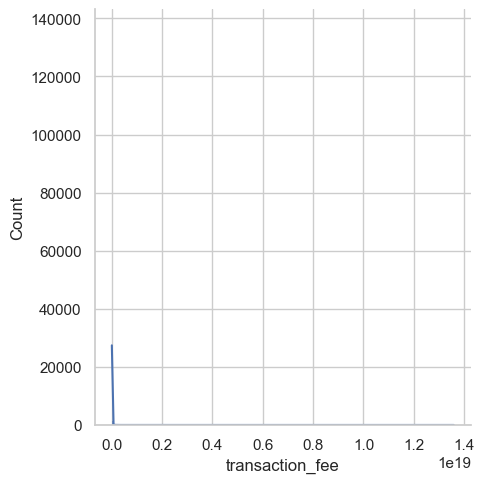

In [33]:
pdf = df.select("transaction_fee").toPandas()
sns.displot(pdf, x="transaction_fee", kde=True)
plt.show()

6. **Relationship between gas price and transaction fee**

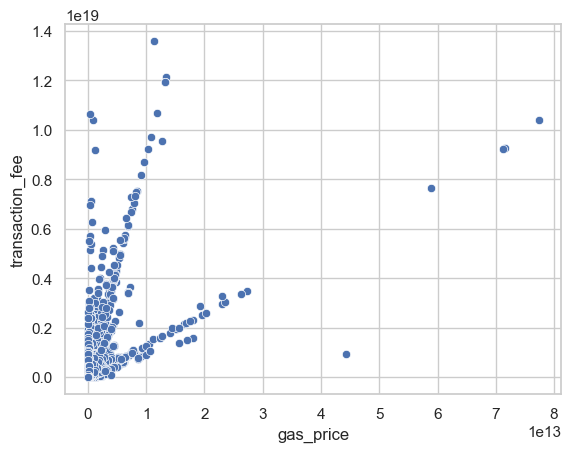

In [34]:
pdf = df.select("gas_price", "transaction_fee").toPandas()
sns.scatterplot(data=pdf, x="gas_price", y="transaction_fee")
plt.show()

7. **Count of transactions per EIP-1559 type**

In [35]:
df.groupBy("transaction_eip-1559_type").count().show()

+-------------------------+-------+
|transaction_eip-1559_type|  count|
+-------------------------+-------+
|                   Legacy|1419754|
|                  Unknown|2175771|
+-------------------------+-------+



8. **Failed transactions vs successful transactions**

In [36]:
df.groupBy("transaction_status").count().show()

+------------------+-------+
|transaction_status|  count|
+------------------+-------+
|           Success|3592007|
|            Failed|   3518|
+------------------+-------+



9. **Transactions before and after EIP1559**

In [37]:
df.groupBy("post_eip1559").count().show()

+------------+-------+
|post_eip1559|  count|
+------------+-------+
|           0|1419754|
|           1|2175771|
+------------+-------+



10. **Distribution of the number of transactions by users**

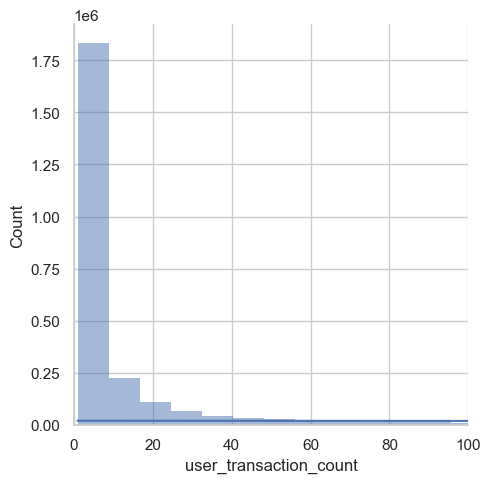

In [47]:
pdf = df.select("user_transaction_count").toPandas()
sns.displot(pdf, x="user_transaction_count", kde=True)
plt.xlim([0, 100])
plt.show()

## More Detailed Preliminary Analysis

Alright, let's deep dive into more detailed analysis of the dataset:

1. **Detailed transactions over time**

We'll create a time series plot to observe the total number of transactions over time. For better granularity, we'll resample the data to daily frequency.

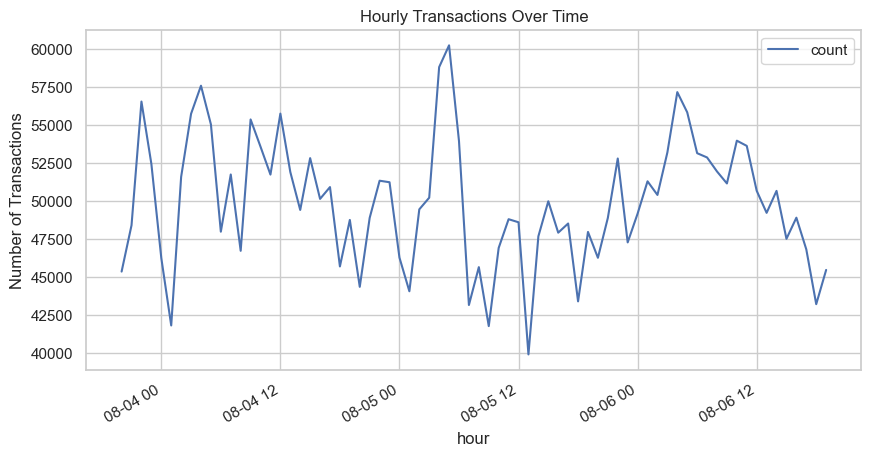

In [48]:
# Create an hour column from timestamp
df = df.withColumn('hour', date_format('transaction_timestamp', 'yyyy-MM-dd HH'))

# Count transactions per hour
df_per_hour = df.groupBy('hour').count()

# Convert to pandas dataframe for plotting
df_per_hour = df_per_hour.toPandas()

# Convert 'hour' back to datetime and set as index for easy plotting
df_per_hour['hour'] = pd.to_datetime(df_per_hour['hour'], format='%Y-%m-%d %H')
df_per_hour.set_index('hour', inplace=True)

# Plot
df_per_hour.plot(figsize=(10,5))
plt.ylabel('Number of Transactions')
plt.title('Hourly Transactions Over Time')
plt.show()

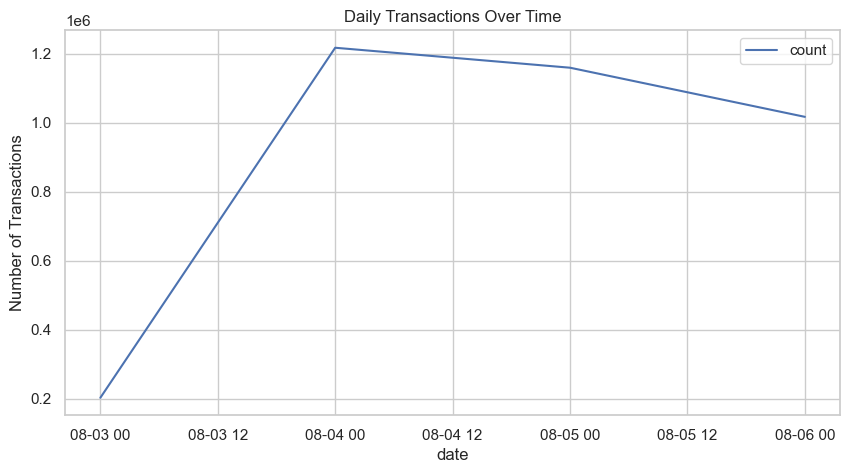

In [39]:
# Create a date column from timestamp
df = df.withColumn('date', to_date('transaction_timestamp'))

# Count transactions per day
df_per_day = df.groupBy('date').count()

# Convert to pandas dataframe for plotting
df_per_day = df_per_day.toPandas()

# Set date as index for easy plotting
df_per_day.set_index('date', inplace=True)

# Plot
df_per_day.plot(figsize=(10,5))
plt.ylabel('Number of Transactions')
plt.title('Daily Transactions Over Time')
plt.show()

2. **Correlation Matrix**

A correlation matrix gives you an idea of how different variables interact with each other.

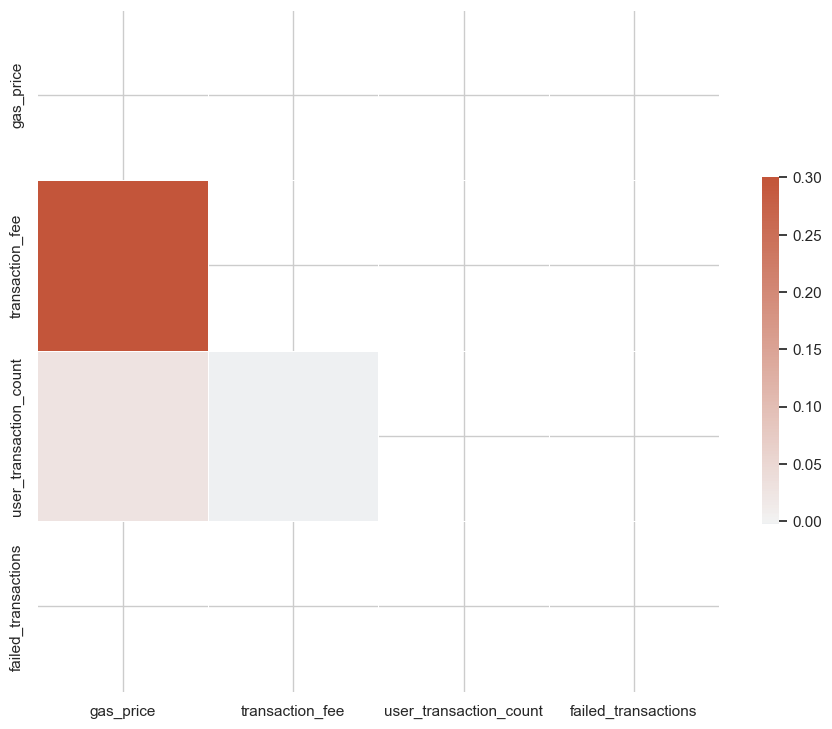

In [42]:
# Select numerical columns
num_df = df.select("gas_price", "transaction_fee", "user_transaction_count", "failed_transactions")

# Convert to pandas dataframe
num_pdf = num_df.toPandas()

# Compute the correlation matrix
corr = num_pdf.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

3. **Gas price over time**

Let's visualize how gas price has changed over time.

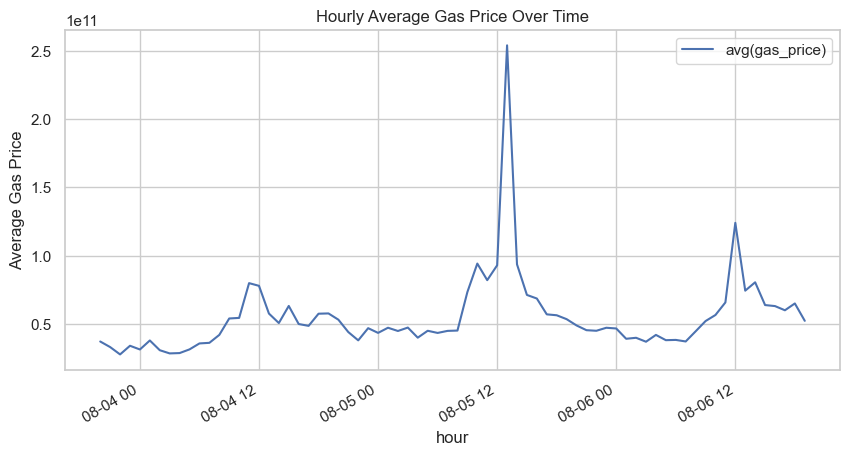

In [50]:
# Compute average gas price per hour
df_gas_price = df.groupBy('hour').agg({"gas_price": "avg"})

# Convert to pandas dataframe for plotting
df_gas_price = df_gas_price.toPandas()

# Convert 'hour' back to datetime and set as index for easy plotting
df_gas_price['hour'] = pd.to_datetime(df_gas_price['hour'], format='%Y-%m-%d %H')
df_gas_price.set_index('hour', inplace=True)

# Plot
df_gas_price.plot(figsize=(10,5))
plt.ylabel('Average Gas Price')
plt.title('Hourly Average Gas Price Over Time')
plt.show()

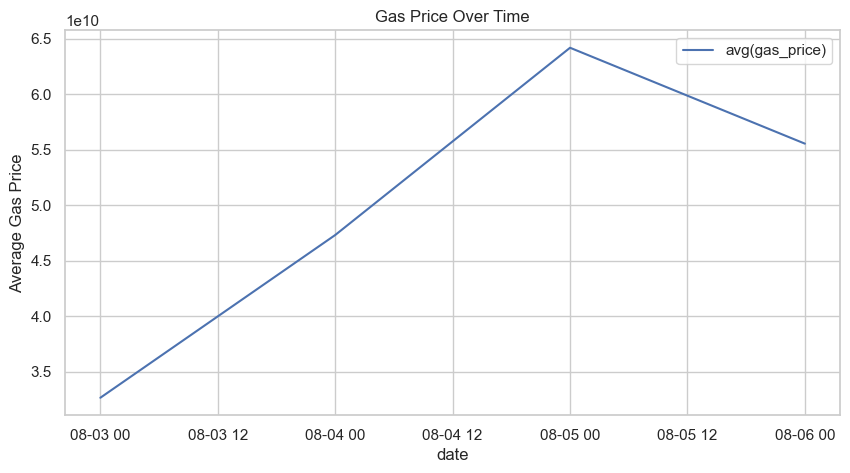

In [43]:
# Compute daily average gas price
df_gas_price = df.groupBy('date').agg({"gas_price": "avg"})

# Convert to pandas dataframe for plotting
df_gas_price = df_gas_price.toPandas()

# Set date as index for easy plotting
df_gas_price.set_index('date', inplace=True)

# Plot
df_gas_price.plot(figsize=(10,5))
plt.ylabel('Average Gas Price')
plt.title('Gas Price Over Time')
plt.show()

4. **Boxplot of transaction fees by transaction type**

Boxplots are great for visualizing statistical measures (median, quartiles etc.) across different categories.

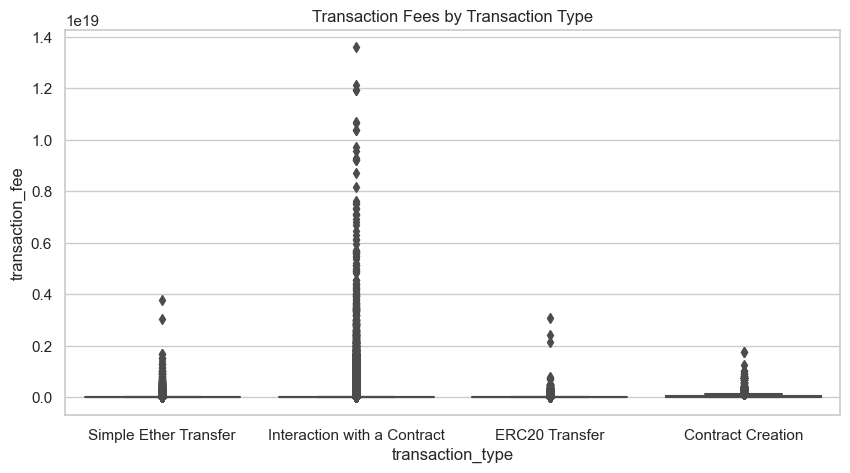

In [44]:
# Select necessary columns
df_fee_type = df.select('transaction_fee', 'transaction_type')

# Convert to pandas dataframe for plotting
df_fee_type = df_fee_type.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='transaction_type', y='transaction_fee', data=df_fee_type)
plt.title('Transaction Fees by Transaction Type')
plt.show()

5. **Number of Transactions Before and After EIP1559**

We can visualize the number of transactions before and after the implementation of EIP1559 to observe if it had any effect.

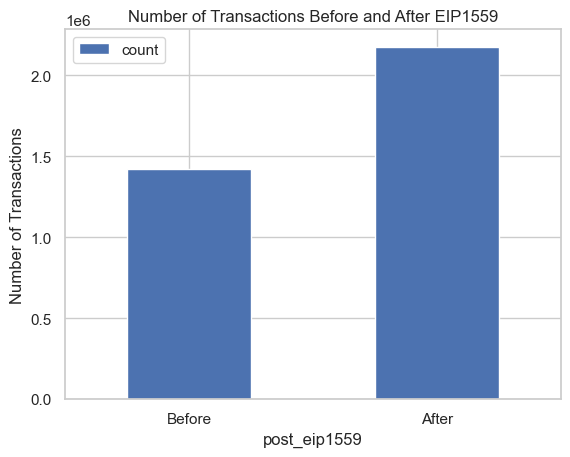

In [46]:
# Group by post_eip1559 and count transactions
df_eip1559 = df.groupBy('post_eip1559').count()

# Convert to pandas dataframe for plotting
df_eip1559 = df_eip1559.toPandas()

# Plot
df_eip1559.plot(kind='bar', x='post_eip1559', y='count')
plt.title('Number of Transactions Before and After EIP1559')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Before', 'After'], rotation=0)  # Replace 0 and 1 with 'Before' and 'After'
plt.show()